In [1]:
!pip install keras-unet-collection==0.1.13
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 11hcgbRcs_9mV1QkiDq8Eb6FKENQClI2f
!pip install patool
import patoolib
patoolib.extract_archive('archive.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11hcgbRcs_9mV1QkiDq8Eb6FKENQClI2f
To: /content/archive.zip
100% 327M/327M [00:03<00:00, 88.3MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 9.2 MB/s eta 0:00:00
patool: Extracting archive.zip ...
patool: running /usr/bin/7z x -o./Unpack_b_ftt0w6 -- archive.zip
patool: ... archive.zip extracted to `archive' (multiple files in root).


'archive'

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend,  optimizers

In [4]:
image_directory = '/content/archive/images/'
mask_directory = '/content/archive/masks/'

In [6]:
import random
import numpy as np
SIZE = 128
image_dataset = []   
mask_dataset = []  
test_image = []
ground_truth = []
flag = 0
images = os.listdir(image_directory)
masks = os.listdir(mask_directory)


for i, image_name in enumerate(images):   
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        if flag%11==0:
          image=cv2.imread(image_directory+image_name)
          test_image.append(image)
        else:
          image=cv2.imread(image_directory+image_name, 1)
          image = Image.fromarray(image)
          image = image.resize((SIZE, SIZE))
          image_dataset.append(np.array(image))
        flag=flag+1

print(len(image_dataset))
print(len(test_image))        


2785
279


In [7]:
flag = 0

for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        if flag%11==0:
          image = cv2.imread(mask_directory+image_name)
          ground_truth.append(image)
        else:
          image = cv2.imread(mask_directory+image_name, 0)
          image = Image.fromarray(image)
          image = image.resize((SIZE, SIZE))
          mask_dataset.append(np.array(image))
        flag=flag+1
        
print(len(mask_dataset))
print(len(ground_truth))

2785
279


In [8]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
print(len(X_train))
print(len(X_val))

2506
279


In [10]:
num_labels = 1  #Binary
input_shape = (128,128,3)
batch_size = 16

In [11]:
from keras_unet_collection import models, losses
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape,Input
from tensorflow import float32


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)
    
model_att_unet = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=1, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG19', weights='imagenet',        # VGG16,ResNet50,VGG19,ResNet101,ResNet152,ResNet50V2, ResNet101V2, ResNet152V2
                           freeze_backbone=True, freeze_batch_norm=True,     #DenseNet121, DenseNet169, DenseNet201,EfficientNetB[0,7]
                           name='attunet')


model_att_unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', losses.dice_coef,iou])

print(model_att_unet.summary())

/usr/local/lib/python3.8/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG19 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


80134624/80134624 [==============================] - 5s 0us/step
Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG19_backbone (Functional)    [(None, 128, 128, 6  20024384    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ply)                                                             'attunet_up2_att_sigmoid[0][0]']
                                                                                                  
 attunet_up2_concat (Concatenat  (None, 64, 64, 256)  0          ['attunet_up2_decode_activation[0
 e)                                                              ][0]',                           
                                                                  'attunet_up2_att_masking[0][0]']
                                                                                                  
 attunet_up2_conv_after_concat_  (None, 64, 64, 128)  294912     ['attunet_up2_concat[0][0]']     
 0 (Conv2D)                                                                                       
                                                                                                  
 attunet_up2_conv_after_concat_  (None, 64, 64, 128)  512        ['attunet_up2_conv_after_concat_0
 0_bn (Bat

In [12]:
model_att_unet_history = model_att_unet.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_val, y_val ), 
                    shuffle=False,
                    epochs=30)
model_att_unet.save('attention_unet_model_brain_tumor.hdf5')
import pandas as pd    
att_unet_history_df = pd.DataFrame(model_att_unet_history.history) 
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)    

Epoch 1/30
157/157 [==============================] - 62s 286ms/step - loss: 0.0932 - accuracy: 0.9774 - dice_coef: 0.1757 - iou: 0.0992 - val_loss: 0.0568 - val_accuracy: 0.9772 - val_dice_coef: 0.2793 - val_iou: 0.1627
Epoch 2/30
157/157 [==============================] - 36s 230ms/step - loss: 0.0363 - accuracy: 0.9866 - dice_coef: 0.4169 - iou: 0.2655 - val_loss: 0.0572 - val_accuracy: 0.9741 - val_dice_coef: 0.4175 - val_iou: 0.2646
Epoch 3/30
157/157 [==============================] - 37s 233ms/step - loss: 0.0276 - accuracy: 0.9882 - dice_coef: 0.5366 - iou: 0.3688 - val_loss: 0.0317 - val_accuracy: 0.9857 - val_dice_coef: 0.5497 - val_iou: 0.3802
Epoch 4/30
157/157 [==============================] - 36s 232ms/step - loss: 0.0238 - accuracy: 0.9890 - dice_coef: 0.5980 - iou: 0.4285 - val_loss: 0.0273 - val_accuracy: 0.9871 - val_dice_coef: 0.6067 - val_iou: 0.4366
Epoch 5/30
157/157 [==============================] - 36s 232ms/step - loss: 0.0203 - accuracy: 0.9900 - dice_coef: 

Training model with callbacks

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")
model_path = os.path.join("files", "attention_unet_model_brain_tumor.h5")
csv_path = os.path.join("files", "attention_unet_model_brain_tumor.csv")
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]
model_att_unet_history = model_att_unet.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_val, y_val), 
                    shuffle=False,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9944 - dice_coef: 0.9047 - iou: 0.8261
Epoch 1: val_loss improved from inf to 0.02777, saving model to files/attention_unet_model_brain_tumor.h5
157/157 [==============================] - 39s 245ms/step - loss: 0.0051 - accuracy: 0.9944 - dice_coef: 0.9047 - iou: 0.8261 - val_loss: 0.0278 - val_accuracy: 0.9896 - val_dice_coef: 0.7565 - val_iou: 0.6110 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9945 - dice_coef: 0.9084 - iou: 0.8323
Epoch 2: val_loss did not improve from 0.02777
157/157 [==============================] - 36s 229ms/step - loss: 0.0050 - accuracy: 0.9945 - dice_coef: 0.9084 - iou: 0.8323 - val_loss: 0.0302 - val_accuracy: 0.9894 - val_dice_coef: 0.7497 - val_iou: 0.6022 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9945 - dice_coef: 0.9106 - iou: 0.8361
Epoch 3: va

1/1 [==============================] - 0s 430ms/step


Text(0.5, 1.0, 'Output')

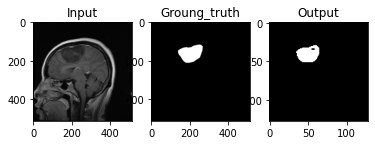

In [19]:
n=0

test_img_input = cv2.resize(test_image[n], (128, 128))
test_img_input = np.expand_dims(test_img_input, 0)
test_img_input = test_img_input / 255.0
test_img_input = test_img_input.astype(np.float32)
model = tf.keras.models.load_model("/content/attention_unet_model_brain_tumor.hdf5",compile=False)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.subplot(1, 3, 1)
plt.imshow(test_image[n])
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(ground_truth[n])
plt.title("Groung_truth")
plt.subplot(1,3,3)
plt.imshow(prediction,cmap='gray')
plt.title("Output")

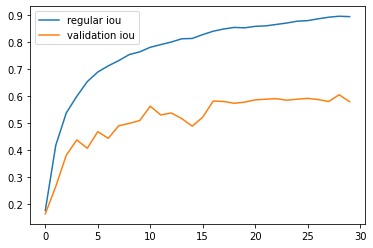

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
x=pd.read_csv("/content/att_unet_history_df.csv")
epoch=x.iloc[:,0:1].values
regular_iou=x.iloc[:,3:4].values
val_iou=x.iloc[:,8:9].values 
plt.plot(epoch,regular_iou,label='regular iou')
plt.plot(epoch,val_iou,label='validation iou')
plt.legend()
plt.show()